# dataset

In [1]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000


Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [00:40<00:00, 29.1MB/s]
100% 5.20G/5.20G [00:40<00:00, 138MB/s] 


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import zipfile

with zipfile.ZipFile("skin-cancer-mnist-ham10000.zip", "r") as zip_ref:
    zip_ref.extractall("HAM10000")


In [7]:
import os

# Check the extracted files
os.listdir("HAM10000")


['hmnist_28_28_L.csv',
 'HAM10000_images_part_2',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_1',
 'hmnist_8_8_RGB.csv',
 'hmnist_28_28_RGB.csv',
 'HAM10000_metadata.csv']

In [6]:
import os
import shutil

dir_path = "HAM10000/ham10000_images_part_1"

if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
else:
    print("Directory does not exist.")


In [8]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=be5d8dcc9569b44363e2ca8b5eb1fb60856a933d71ae2fa0eba35b26fafd9eab
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


# 1. import and Setup:

In [86]:
from google.colab import drive
import os
from glob import glob
from tqdm import tqdm

from torch.cuda.amp import autocast, GradScaler
from efficientnet_pytorch import EfficientNet


import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.ion()   # interactive mode

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [87]:
os.listdir("HAM10000")

['hmnist_28_28_L.csv',
 'HAM10000_images_part_2',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_1',
 'hmnist_8_8_RGB.csv',
 'hmnist_28_28_RGB.csv',
 'HAM10000_metadata.csv']

# 2. Dataset Loading and Preparation

In [88]:
base_dir = os.path.join('HAM10000' )
all_image_path = glob(os.path.join(base_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


In [89]:
print("Number of images found:", len(all_image_path))
print("Sample paths:", all_image_path[:5])  # Print a few paths if any exist
# print("Contents of base_dir:", os.listdir(base_dir))
print("Base directory path:", base_dir)


Number of images found: 10015
Sample paths: ['HAM10000/HAM10000_images_part_2/ISIC_0033634.jpg', 'HAM10000/HAM10000_images_part_2/ISIC_0031975.jpg', 'HAM10000/HAM10000_images_part_2/ISIC_0031043.jpg', 'HAM10000/HAM10000_images_part_2/ISIC_0033585.jpg', 'HAM10000/HAM10000_images_part_2/ISIC_0029990.jpg']
Base directory path: HAM10000


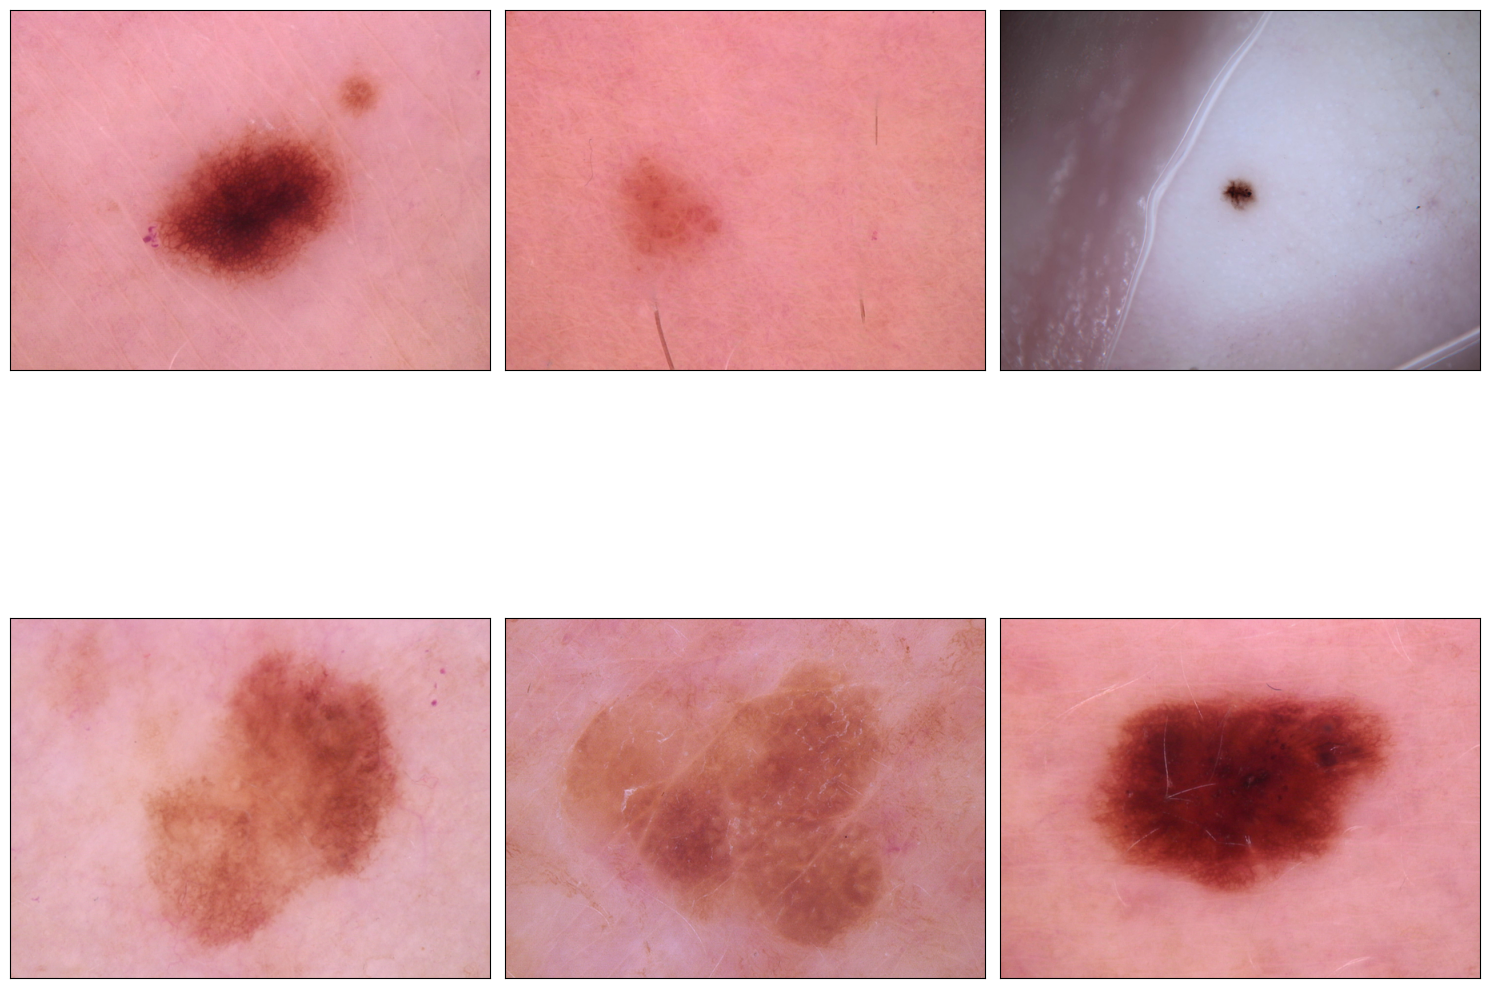

In [90]:
w, h = 10, 10
fig = plt.figure(figsize=(15, 15))
columns, rows = 3, 2
start, end = 0, len(imageid_path_dict)
ax = []
import random
for i in range(columns*rows):
    k = random.randint(start, end)
    img = mpimg.imread((all_image_path[k]))
#     title = (train_df.iloc[k,0]).split('/')
#     title = title[2]+'-'+title[3]+'-'+title[4]
#     k += 1
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
#     ax[-1].set_title(title)  # set title
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="gray")
plt.tight_layout()
plt.show()  # finally, render the plot

In [91]:
# Checking the size and number of channels in the image
arr = np.asarray(Image.open(all_image_path[48]))
arr.shape

(450, 600, 3)

In [92]:
df_original = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,HAM10000/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,HAM10000/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,HAM10000/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,HAM10000/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,HAM10000/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


Dx is short for diagnosis (for the patient) and dx_type is how the diagnosis was made.
A bit more about each type of diagnosis and how they were made is available in the original paper https://arxiv.org/abs/1803.10417

In [93]:
df_original[['cell_type_idx', 'cell_type']].sort_values('cell_type_idx').drop_duplicates()

,cell_type_idx,cell_type
9804,0,Actinic keratoses
2528,1,Basal cell carcinoma
1018,2,Benign keratosis-like lesions
1159,3,Dermatofibroma
7050,4,Melanocytic nevi
2370,5,Vascular lesions
1577,6,melanoma


In the table above we have a nice overview of our groundtruth data. What we care for is only the column 'cell_type_idx', because these values are needed for the model training.
But of course it is nice to know what these labels mean, that is what the column 'cell_type' is for. Lets quickly check how often the different tumors occur in our dataset:

In [94]:
df_original['cell_type'].value_counts()

,count
cell_type,
Melanocytic nevi,6705
melanoma,1113
Benign keratosis-like lesions,1099
Basal cell carcinoma,514
Actinic keratoses,327
Vascular lesions,142
Dermatofibroma,115


# 3. Data Preprocessing

In [95]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [96]:
# norm_mean,norm_std = compute_img_mean_std(all_image_path)

In [97]:
normMean = [0.7630362, 0.5456468, 0.5700442]
normStd = [0.14092818, 0.15261286, 0.16997077]
# for future reference

In [98]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [99]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,HAM10000/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,HAM10000/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,HAM10000/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,HAM10000/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,HAM10000/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated


In [100]:
df_original['duplicates'].value_counts()

,count
duplicates,
unduplicated,5514
duplicated,4501


In [101]:
# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [102]:
# now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [103]:
df_val['cell_type_idx'].value_counts()

,count
cell_type_idx,
4,883
2,88
6,46
1,35
0,30
5,13
3,8


In [104]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))


8912
1103


In [105]:
df_train['cell_type'].value_counts()

,count
cell_type,
Melanocytic nevi,5822
melanoma,1067
Benign keratosis-like lesions,1011
Basal cell carcinoma,479
Actinic keratoses,297
Vascular lesions,129
Dermatofibroma,107


In [106]:
df_val['cell_type'].value_counts()


,count
cell_type,
Melanocytic nevi,883
Benign keratosis-like lesions,88
melanoma,46
Basal cell carcinoma,35
Actinic keratoses,30
Vascular lesions,13
Dermatofibroma,8


From From the above statistics of each category, we can see that there is a serious class imbalance in the training data. To solve this problem, I think we can start from two aspects, one is equalization sampling, and the other is a loss function that can be used to mitigate category imbalance during training, such as focal loss.

In [107]:
# Copy fewer class to balance the number of 7 classes
data_aug_rate = [15,10,5,50,0,40,5]
for i in range(7):
    if data_aug_rate[i]:
        df_train = pd.concat([df_train] + [df_train.loc[df_train['cell_type_idx'] == i, :]] * (data_aug_rate[i] - 1), ignore_index=True)
df_train['cell_type'].value_counts()

,count
cell_type,
Melanocytic nevi,5822
Dermatofibroma,5350
melanoma,5335
Vascular lesions,5160
Benign keratosis-like lesions,5055
Basal cell carcinoma,4790
Actinic keratoses,4455


In [108]:
df_train = df_train.reset_index()
df_val = df_val.reset_index()

In [109]:
df_train.sample(5)

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates,train_or_val
30975,30975,HAM_0004791,ISIC_0033135,vasc,histo,80.0,female,lower extremity,HAM10000/HAM10000_images_part_2/ISIC_0033135.jpg,Vascular lesions,5,duplicated,train
12375,12375,HAM_0000005,ISIC_0029638,akiec,histo,75.0,female,lower extremity,HAM10000/HAM10000_images_part_2/ISIC_0029638.jpg,Actinic keratoses,0,duplicated,train
28242,28242,HAM_0007614,ISIC_0029514,vasc,histo,55.0,female,face,HAM10000/HAM10000_images_part_2/ISIC_0029514.jpg,Vascular lesions,5,duplicated,train
13962,13962,HAM_0002812,ISIC_0029053,bcc,histo,75.0,female,back,HAM10000/HAM10000_images_part_1/ISIC_0029053.jpg,Basal cell carcinoma,1,duplicated,train
31290,31290,HAM_0004943,ISIC_0027790,vasc,consensus,50.0,female,face,HAM10000/HAM10000_images_part_1/ISIC_0027790.jpg,Vascular lesions,5,unduplicated,train


In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# 4. Model Definition

In [111]:
# Define a class for EfficientNet-B0 model
class PretrainedEfficientNet(nn.Module):
    def __init__(self, num_class=7):
        super().__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
        self.fc1 = nn.Linear(self.efficientnet._fc.in_features, num_class)

    def forward(self, x):
        x = self.efficientnet.extract_features(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [112]:
# Initialize the model with EfficientNet-B0
model = PretrainedEfficientNet(num_class=7)
model.to(device)

Loaded pretrained weights for efficientnet-b0


PretrainedEfficientNet(
  (efficientnet): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dS

# 5. Data Transformation

In [113]:
input_size = 224  # Update input size for EfficientNet-B0

train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(normMean, normStd)
])

val_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(normMean, normStd)
])



# 6. Custom Dataset and Dataloader

In [114]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)
        return X, y

In [115]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = CustomDataset(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)
# Same for the validation set:
validation_set = CustomDataset(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [116]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# 7. Training and Validation Functions

In [117]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.shape, 'label shape',labels.shape)
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [118]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

# 8. Model Training Loop

In [119]:
model = PretrainedEfficientNet(num_class=7)
model.to(device)
# class_weights = torch.tensor([1/6705, 1/1113, 1/1099, 1/514, 1/327, 1/142, 1/115], dtype=torch.float32).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)
##above two lines for Use class weighting during training to ensure the loss function penalizes errors on minority classes:adress class imbalance
criterion = nn.CrossEntropyLoss().to(device)

Loaded pretrained weights for efficientnet-b0


In [120]:
# Define the path to save the model on Google Drive
model_path = '/content/drive/MyDrive/best_model.pth'
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Lower learning rate for EfficientNet-B0


epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [], []

for epoch in tqdm(range(1, epoch_num+1)):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)

    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')
        # Save the model to Google Drive
        torch.save(model.state_dict(), model_path)


  0%|          | 0/10 [00:00<?, ?it/s]

[epoch 1], [iter 100 / 1124], [train loss 1.60519], [train acc 0.44125]
[epoch 1], [iter 200 / 1124], [train loss 1.26965], [train acc 0.55203]
[epoch 1], [iter 300 / 1124], [train loss 1.08962], [train acc 0.61250]
[epoch 1], [iter 400 / 1124], [train loss 0.96826], [train acc 0.65539]
[epoch 1], [iter 500 / 1124], [train loss 0.88679], [train acc 0.68331]
[epoch 1], [iter 600 / 1124], [train loss 0.82396], [train acc 0.70526]
[epoch 1], [iter 700 / 1124], [train loss 0.77392], [train acc 0.72384]
[epoch 1], [iter 800 / 1124], [train loss 0.73092], [train acc 0.73809]
[epoch 1], [iter 900 / 1124], [train loss 0.69546], [train acc 0.75073]
[epoch 1], [iter 1000 / 1124], [train loss 0.66608], [train acc 0.76103]
[epoch 1], [iter 1100 / 1124], [train loss 0.64059], [train acc 0.76969]


 10%|█         | 1/10 [09:13<1:22:57, 553.04s/it]

------------------------------------------------------------
[epoch 1], [val loss 0.28954], [val acc 0.89464]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.28954], [val acc 0.89464]
*****************************************************
[epoch 2], [iter 100 / 1124], [train loss 0.32723], [train acc 0.88531]
[epoch 2], [iter 200 / 1124], [train loss 0.33604], [train acc 0.87797]
[epoch 2], [iter 300 / 1124], [train loss 0.33303], [train acc 0.87823]
[epoch 2], [iter 400 / 1124], [train loss 0.32118], [train acc 0.88187]
[epoch 2], [iter 500 / 1124], [train loss 0.31315], [train acc 0.88556]
[epoch 2], [iter 600 / 1124], [train loss 0.31062], [train acc 0.88755]
[epoch 2], [iter 700 / 1124], [train loss 0.30522], [train acc 0.88884]
[epoch 2], [iter 800 / 1124], [train loss 0.30056], [train acc 0.89047]
[epoch 2], [iter 900 / 1124], [train loss 0.29660], [train acc 0.89153]
[epoch 2], 

 20%|██        | 2/10 [18:25<1:13:40, 552.57s/it]

------------------------------------------------------------
[epoch 2], [val loss 0.28794], [val acc 0.91161]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 0.28794], [val acc 0.91161]
*****************************************************
[epoch 3], [iter 100 / 1124], [train loss 0.21322], [train acc 0.92156]
[epoch 3], [iter 200 / 1124], [train loss 0.21024], [train acc 0.92219]
[epoch 3], [iter 300 / 1124], [train loss 0.20798], [train acc 0.92417]
[epoch 3], [iter 400 / 1124], [train loss 0.20454], [train acc 0.92617]
[epoch 3], [iter 500 / 1124], [train loss 0.20477], [train acc 0.92594]
[epoch 3], [iter 600 / 1124], [train loss 0.20266], [train acc 0.92641]
[epoch 3], [iter 700 / 1124], [train loss 0.20378], [train acc 0.92576]
[epoch 3], [iter 800 / 1124], [train loss 0.20224], [train acc 0.92688]
[epoch 3], [iter 900 / 1124], [train loss 0.20082], [train acc 0.92740]
[epoch 3], 

 30%|███       | 3/10 [27:24<1:03:46, 546.66s/it]

------------------------------------------------------------
[epoch 3], [val loss 0.26816], [val acc 0.90792]
------------------------------------------------------------
[epoch 4], [iter 100 / 1124], [train loss 0.16368], [train acc 0.94000]
[epoch 4], [iter 200 / 1124], [train loss 0.15182], [train acc 0.94484]
[epoch 4], [iter 300 / 1124], [train loss 0.15019], [train acc 0.94510]
[epoch 4], [iter 400 / 1124], [train loss 0.14973], [train acc 0.94406]
[epoch 4], [iter 500 / 1124], [train loss 0.14720], [train acc 0.94488]
[epoch 4], [iter 600 / 1124], [train loss 0.14848], [train acc 0.94474]
[epoch 4], [iter 700 / 1124], [train loss 0.14842], [train acc 0.94522]
[epoch 4], [iter 800 / 1124], [train loss 0.14733], [train acc 0.94574]
[epoch 4], [iter 900 / 1124], [train loss 0.14629], [train acc 0.94628]
[epoch 4], [iter 1000 / 1124], [train loss 0.14555], [train acc 0.94684]
[epoch 4], [iter 1100 / 1124], [train loss 0.14384], [train acc 0.94730]


 40%|████      | 4/10 [36:30<54:38, 546.34s/it]  

------------------------------------------------------------
[epoch 4], [val loss 0.35264], [val acc 0.89976]
------------------------------------------------------------
[epoch 5], [iter 100 / 1124], [train loss 0.10740], [train acc 0.96125]
[epoch 5], [iter 200 / 1124], [train loss 0.11240], [train acc 0.95906]
[epoch 5], [iter 300 / 1124], [train loss 0.11129], [train acc 0.96021]
[epoch 5], [iter 400 / 1124], [train loss 0.11472], [train acc 0.95914]
[epoch 5], [iter 500 / 1124], [train loss 0.11510], [train acc 0.95900]
[epoch 5], [iter 600 / 1124], [train loss 0.11434], [train acc 0.95943]
[epoch 5], [iter 700 / 1124], [train loss 0.11556], [train acc 0.95893]
[epoch 5], [iter 800 / 1124], [train loss 0.11635], [train acc 0.95895]
[epoch 5], [iter 900 / 1124], [train loss 0.11522], [train acc 0.95920]
[epoch 5], [iter 1000 / 1124], [train loss 0.11503], [train acc 0.95937]
[epoch 5], [iter 1100 / 1124], [train loss 0.11507], [train acc 0.95889]


 50%|█████     | 5/10 [45:36<45:30, 546.15s/it]

------------------------------------------------------------
[epoch 5], [val loss 0.31675], [val acc 0.91851]
------------------------------------------------------------
*****************************************************
best record: [epoch 5], [val loss 0.31675], [val acc 0.91851]
*****************************************************
[epoch 6], [iter 100 / 1124], [train loss 0.08954], [train acc 0.97031]
[epoch 6], [iter 200 / 1124], [train loss 0.09097], [train acc 0.96922]
[epoch 6], [iter 300 / 1124], [train loss 0.09469], [train acc 0.96688]
[epoch 6], [iter 400 / 1124], [train loss 0.09479], [train acc 0.96703]
[epoch 6], [iter 500 / 1124], [train loss 0.09339], [train acc 0.96750]
[epoch 6], [iter 600 / 1124], [train loss 0.09302], [train acc 0.96802]
[epoch 6], [iter 700 / 1124], [train loss 0.09571], [train acc 0.96652]
[epoch 6], [iter 800 / 1124], [train loss 0.09653], [train acc 0.96621]
[epoch 6], [iter 900 / 1124], [train loss 0.09595], [train acc 0.96632]
[epoch 6], 

 60%|██████    | 6/10 [54:32<36:11, 542.80s/it]

------------------------------------------------------------
[epoch 6], [val loss 0.33828], [val acc 0.92042]
------------------------------------------------------------
*****************************************************
best record: [epoch 6], [val loss 0.33828], [val acc 0.92042]
*****************************************************
[epoch 7], [iter 100 / 1124], [train loss 0.08587], [train acc 0.97125]
[epoch 7], [iter 200 / 1124], [train loss 0.09100], [train acc 0.96875]
[epoch 7], [iter 300 / 1124], [train loss 0.08469], [train acc 0.96990]
[epoch 7], [iter 400 / 1124], [train loss 0.08459], [train acc 0.97031]
[epoch 7], [iter 500 / 1124], [train loss 0.08199], [train acc 0.97144]
[epoch 7], [iter 600 / 1124], [train loss 0.08165], [train acc 0.97141]
[epoch 7], [iter 700 / 1124], [train loss 0.08324], [train acc 0.97107]
[epoch 7], [iter 800 / 1124], [train loss 0.08188], [train acc 0.97160]
[epoch 7], [iter 900 / 1124], [train loss 0.08160], [train acc 0.97128]
[epoch 7], 

 70%|███████   | 7/10 [1:03:31<27:04, 541.55s/it]

------------------------------------------------------------
[epoch 7], [val loss 0.30922], [val acc 0.91685]
------------------------------------------------------------
[epoch 8], [iter 100 / 1124], [train loss 0.07821], [train acc 0.97000]
[epoch 8], [iter 200 / 1124], [train loss 0.07527], [train acc 0.97188]
[epoch 8], [iter 300 / 1124], [train loss 0.07626], [train acc 0.97188]
[epoch 8], [iter 400 / 1124], [train loss 0.07231], [train acc 0.97320]
[epoch 8], [iter 500 / 1124], [train loss 0.07051], [train acc 0.97425]
[epoch 8], [iter 600 / 1124], [train loss 0.06867], [train acc 0.97469]
[epoch 8], [iter 700 / 1124], [train loss 0.06742], [train acc 0.97518]
[epoch 8], [iter 800 / 1124], [train loss 0.06703], [train acc 0.97520]
[epoch 8], [iter 900 / 1124], [train loss 0.06582], [train acc 0.97566]
[epoch 8], [iter 1000 / 1124], [train loss 0.06542], [train acc 0.97613]
[epoch 8], [iter 1100 / 1124], [train loss 0.06536], [train acc 0.97634]


 80%|████████  | 8/10 [1:12:30<18:01, 540.53s/it]

------------------------------------------------------------
[epoch 8], [val loss 0.42699], [val acc 0.91238]
------------------------------------------------------------
[epoch 9], [iter 100 / 1124], [train loss 0.06216], [train acc 0.97844]
[epoch 9], [iter 200 / 1124], [train loss 0.05784], [train acc 0.97906]
[epoch 9], [iter 300 / 1124], [train loss 0.05804], [train acc 0.97875]
[epoch 9], [iter 400 / 1124], [train loss 0.05686], [train acc 0.97969]
[epoch 9], [iter 500 / 1124], [train loss 0.05728], [train acc 0.97944]
[epoch 9], [iter 600 / 1124], [train loss 0.05834], [train acc 0.97906]
[epoch 9], [iter 700 / 1124], [train loss 0.05773], [train acc 0.97946]
[epoch 9], [iter 800 / 1124], [train loss 0.05716], [train acc 0.97984]
[epoch 9], [iter 900 / 1124], [train loss 0.05664], [train acc 0.97990]
[epoch 9], [iter 1000 / 1124], [train loss 0.05693], [train acc 0.97975]
[epoch 9], [iter 1100 / 1124], [train loss 0.05758], [train acc 0.97955]


 90%|█████████ | 9/10 [1:21:19<08:57, 537.02s/it]

------------------------------------------------------------
[epoch 9], [val loss 0.31920], [val acc 0.92399]
------------------------------------------------------------
*****************************************************
best record: [epoch 9], [val loss 0.31920], [val acc 0.92399]
*****************************************************
[epoch 10], [iter 100 / 1124], [train loss 0.04340], [train acc 0.98344]
[epoch 10], [iter 200 / 1124], [train loss 0.04797], [train acc 0.98234]
[epoch 10], [iter 300 / 1124], [train loss 0.04906], [train acc 0.98229]
[epoch 10], [iter 400 / 1124], [train loss 0.05239], [train acc 0.98211]
[epoch 10], [iter 500 / 1124], [train loss 0.05249], [train acc 0.98200]
[epoch 10], [iter 600 / 1124], [train loss 0.05173], [train acc 0.98234]
[epoch 10], [iter 700 / 1124], [train loss 0.05146], [train acc 0.98241]
[epoch 10], [iter 800 / 1124], [train loss 0.05038], [train acc 0.98293]
[epoch 10], [iter 900 / 1124], [train loss 0.05048], [train acc 0.98278]
[e

100%|██████████| 10/10 [1:30:06<00:00, 540.67s/it]

------------------------------------------------------------
[epoch 10], [val loss 0.42862], [val acc 0.91774]
------------------------------------------------------------


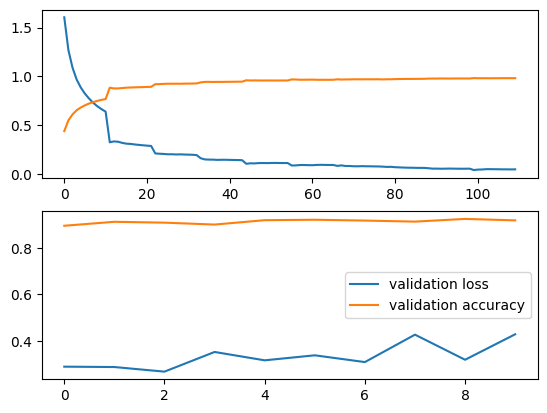

In [121]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

In [122]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 9. Evaluation and Metrics

In [123]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
# plot_confusion_matrix(confusion_mtx, plot_labels)


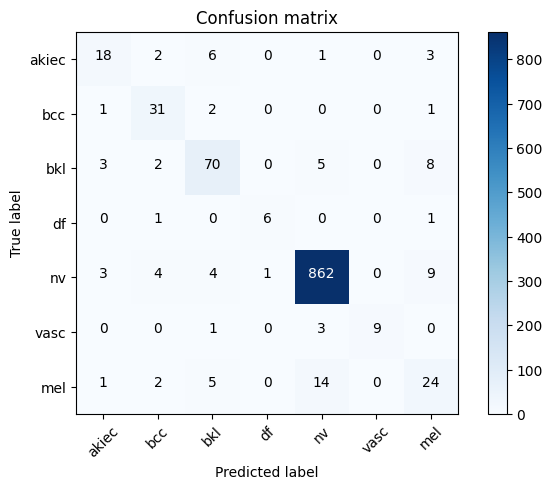

In [124]:
import itertools
plot_confusion_matrix(confusion_mtx, plot_labels)


In [125]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.69      0.60      0.64        30
         bcc       0.74      0.89      0.81        35
         bkl       0.80      0.80      0.80        88
          df       0.86      0.75      0.80         8
          nv       0.97      0.98      0.98       883
        vasc       1.00      0.69      0.82        13
         mel       0.52      0.52      0.52        46

    accuracy                           0.92      1103
   macro avg       0.80      0.75      0.77      1103
weighted avg       0.93      0.92      0.92      1103



Text(0, 0.5, 'Fraction classified incorrectly')

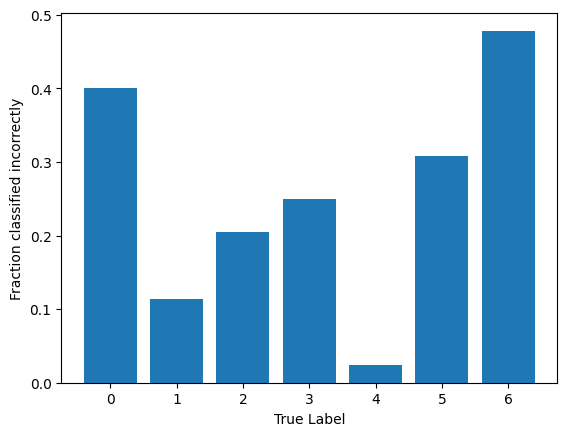

In [126]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')